# IMDB 5000 Movie Dataset Clustering

===========================================================================================================

**AUTHOR**: Mengshan Jin

**CREATION DATE**: 08/04/2017

===========================================================================================================

**PROGRAM DESCRIPTION**: Clustering on the movies using the text data only with ngram methods

**INPUT DATASETS**: 01_Data/Outputs/imdb_with_storyline.csv

**OUTPUT DATASETS**: 

**SCOPE**: 1980-2016 English movies

===========================================================================================================

**PROGRAM CHANGE HISTORY**

Date|Author|Change|
----|------|------|
08/08/2017|Mengshan Jin|Added Agglomerative Clustering with Complete Linkage and Average Linkage, and KMeans to the program

# Section 0: Import packages

In [1]:
# Data structure
import numpy as np
import pandas as pd
np.random.seed(7)
# pd.options.mode.chained_assignment = None  # default='warn'

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set(style="ticks", color_codes=True)

# utilities
import copy
import re
import string

# nltk
from nltk.tokenize import word_tokenize, MWETokenizer
from nltk.tag import StanfordNERTagger
from nltk.corpus import stopwords

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.externals import joblib

# Section 1: Read data

In [2]:
imdb_with_storyline = pd.read_csv("../../01_Data/Outputs/imdb_with_storyline.csv")

In [3]:
imdb_with_storyline.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes,storyline
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000,"When his brother is killed in a robbery, parap..."
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0,"After Elizabeth, Will, and Captain Barbossa re..."
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000,A cryptic message from the past sends James Bo...
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000,Despite his tarnished reputation after the eve...
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0,NaN


In [4]:
imdb_with_storyline = imdb_with_storyline.drop_duplicates()

In [5]:
imdb_with_storyline.shape

(4998, 29)

# Section 2: Clustering with Text

## Step 1: Split the dataset into training and out-of-time sample testing datasets

In [6]:
imdb_train = imdb_with_storyline.loc[(imdb_with_storyline['title_year'] < 2015) & (imdb_with_storyline['title_year'] >= 1980) & 
                                     (imdb_with_storyline['language'] == "English")]
imdb_test = imdb_with_storyline.loc[(imdb_with_storyline['title_year'] >= 2015) & (imdb_with_storyline['language'] == "English")]

In [7]:
imdb_train.shape

(4024, 29)

In [8]:
imdb_test.shape

(301, 29)

### ==>Task to do<==
Inconsistent number of observations for codified data and text data.    
When combining, need to re-pull storyline based on imdb_modern_cleaned

## Step 2: Subset the storyline

In [9]:
storyline_train = pd.DataFrame(imdb_train[['storyline', 'imdb_score', 'num_critic_for_reviews']]).set_index(imdb_train['movie_title'])

In [10]:
storyline_train.head()

,storyline,imdb_score,num_critic_for_reviews
movie_title,,,
Avatar,"When his brother is killed in a robbery, parap...",7.9,723.0
Pirates of the Caribbean: At World's End,"After Elizabeth, Will, and Captain Barbossa re...",7.1,302.0
The Dark Knight Rises,Despite his tarnished reputation after the eve...,8.5,813.0
John Carter,"John Carter, a Civil War veteran, who in 1868 ...",6.6,462.0
Spider-Man 3,Peter Parker has finally managed to piece toge...,6.2,392.0


In [11]:
storyline_train.loc[storyline_train['storyline'].isnull()]

,storyline,imdb_score,num_critic_for_reviews
movie_title,,,
Michael Jordan to the Max,NaN,7.5,14.0


In [12]:
storyline_train['storyline'].fillna("NA", inplace=True)

In [13]:
storyline_train.loc['Michael Jordan to the Max\xc2\xa0']

storyline                  NA
imdb_score                7.5
num_critic_for_reviews     14
Name: Michael Jordan to the Max , dtype: object

## Step 3: Build pipeline to train models

In [14]:
stop_list = stopwords.words('english') + ["'s", "n't", "``", "", "...", "--"]

In [15]:
def text2int(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):    numwords[word] = (1, idx)
        for idx, word in enumerate(tens):     numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales):   numwords[word] = (10 ** (idx * 3 or 2), 0)

    current = result = 0
    for word in textnum.split():
        if word not in numwords:
            raise Exception("Illegal word: " + word)
        scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [16]:
def summarize_x_year_old(x_year_old):
    tmp = re.sub('-', ' ', re.split(r'-year-old', x_year_old)[0])
    try:
        x = int(tmp)
    except ValueError:
        try:
            x = text2int(tmp)
        except Exception:
            return x_year_old
    if x < 12:
        return "childhood"
    elif x < 21:
        return "adolescence"
    elif x < 36:
        return "early-adulthood"
    elif x < 51:
        return "midlife"
    else:
        return "late-adulthood"

In [17]:
synonyms = {
    'dr.':'doctor',
    'u.s.':'united-states',
    "'ll":"will",
    "'ve":"have",
    "'d":"would",
    'l.a.':'los-angeles',
    'year-old':'year old',
    'jr.':'junior',
    'small-town':'small town',
    'real-life':'real life',
    'co-worker':'colleague',
    'a.k.a':'also known as',
    'st.':'street',
    'would-be':'would be',
    'long-time':'long time',
    'self-defense':'self defense',
    'co-workers':'colleague',
    'modern-day':'modern',
    'd.c.':'washington-dc',
    'top-secret':'top secret',
    'next-door':'neighbor',
    'face-to-face':'face to face',
    'mild-mannered':'mild manner',
    'part-time':'part time',
    'self-discovery':'self discovery',
    'one-time':'one time',
    'high-speed':'high speed',
    'high-tech':'high technology',
    'so-called':'so called',
    'new-found':'newly found',
    'long-term':'long term',
    'u.s':'united states',
    'sci-fi':'science fiction',
    'up-and-coming':'upcoming',
    'soon-to-be':'soon to be',
    'all-out':'all out',
    'one-night':'one night',
    'best-selling':'best selling',
    '3-d':'3 dimensions',
    'husband-and-wife':'husband and wife',
    'wedding-plans':'wedding plans',
    'salesman/font':'salesman',
    'mid-twenty-year-old':'young adulthood',
    'ten-and-a-half-year-old':'childhood'
}

In [18]:
def custom_tokenizer(storyline):
    token_list = [item.lower().strip("'") for item in word_tokenize(storyline) if item not in string.punctuation]
    tokens = [item for item in token_list if item not in stop_list]
    tokens_clean_years = [summarize_x_year_old(x) if x.find("-year-old") != -1 else x for x in tokens]
    tokens_sub_synonyms = [x if x not in synonyms.keys() else synonyms[x] for x in tokens_clean_years]
    tokens_remove_dot = [x for x in tokens_sub_synonyms if re.match(r"[a-z]\.$", x) == None]
    tokens_split = [x for item in tokens_remove_dot for x in item.split(" ")]
    tokens = [item for item in tokens_split if item not in stop_list]
    return tokens

In [19]:
def standardized_measure(df, col):
    return (df[col] - df[col].min())/(df[col].max() - df[col].min())

In [20]:
def harmonic_mean(row):
    try:
        return 1/(0.7*row[0]+0.3*row[1])
    except ZeroDivisionError:
        return np.nan

In [21]:
def goodness_deviance(list_num):
    num_avg = np.mean(list_num)
    return np.sqrt(np.sum([(item-num_avg)**2 for item in list_num])/len(list_num))

In [22]:
# write my own loop function to select the best combination of parameters
def clustering_grid_search_text(df, text_col, pipe, param_grid):
    best_i = -1
    best_dev = 0
    res_dict = {}
    for i in range(len(param_grid)):
        cluster_model = pipe.set_params(**param_grid[i])
        cluster_pred = cluster_model.fit_predict(df[text_col])
        tmp = pd.concat([df[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                         pd.Series(cluster_pred, name="cluster_num")], axis=1)
        tmp['imdb_score'] = standardized_measure(tmp, 'imdb_score')
        tmp['num_critic_for_reviews'] = standardized_measure(tmp, 'num_critic_for_reviews')
        tmp['harmonic_mean'] = tmp[['imdb_score', 'num_critic_for_reviews']].apply(harmonic_mean, axis = 1)
        tmp_gp = tmp.groupby('cluster_num').aggregate({'harmonic_mean':np.mean})
        curr_dev = goodness_deviance(tmp_gp['harmonic_mean'])
        res_dict[i] = [param_grid[i], {"Deviance":curr_dev}]
        if curr_dev > best_dev:
            best_dev = curr_dev
            best_i = i
    print "Best parameters combination:", param_grid[best_i], "\nDeviance:", best_dev
    return res_dict

## Models to choose from:
1. Agglomerative Clustering (3 linkages)
2. KMeans
3. DBSCAN

### Agglomerative Clustering with Ward linkage criterion
Use SVD to reduce dimensions

In [58]:
pipe_count_svd_ward = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list,
                                                          tokenizer=custom_tokenizer,
                                                          ngram_range=(1,4))),
                               ('svd', TruncatedSVD()),
                               ('normalizer', Normalizer(copy=False)),
                               ('clustering', AgglomerativeClustering())
                              ])

param_grid_svd_ward = {'vectorizer__max_df':[0.5,0.6,0.7,0.8],
                       'vectorizer__min_df':list(np.arange(5,9)),
                       'svd__n_components':[50,75,100,125],
                       'clustering__n_clusters':[10, 30, 50]}
param_grid_svd_ward = list(ParameterGrid(param_grid_svd_ward))

In [66]:
res_count_svd_ward = clustering_grid_search_text(storyline_train, "storyline", pipe_count_svd_ward, param_grid_svd_ward)

Best parameters combination: {'vectorizer__min_df': 8, 'vectorizer__max_df': 0.8, 'clustering__n_clusters': 50, 'svd__n_components': 125} 
Deviance: 0.376550531093


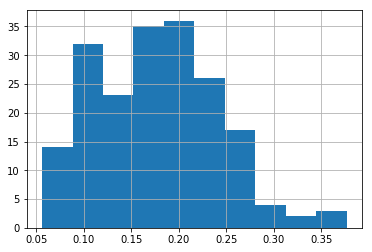

In [67]:
# check deviance distribution
lrs_count_svd_ward = [value[1]['Deviance'] for value in res_count_svd_ward.values()]
pd.Series(lrs_count_svd_ward).hist()

In [69]:
joblib.dump(res_count_svd_ward, 'pickles/count_svd_ward_params.pkl', compress=1) # pickle the parameters and the results

['pickles/count_svd_ward_params.pkl']

#### Investigation
1. Size of each cluster
2. Differentiation between good movies and bad movies
3. Quality of Inception group

In [27]:
def get_best_model_id(res_dict):
    return sorted({key:value[1]['Deviance'] for key, value in res_dict.items()}.items(), key=lambda t: t[1], reverse=True)[0][0]

In [80]:
count_svd_ward_best_model = pipe_count_svd_ward.set_params(**param_grid_svd_ward[get_best_model_id(res_count_svd_ward)])

In [82]:
tmp = pd.concat([storyline_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                 pd.Series(count_svd_ward_best_model.fit_predict(storyline_train['storyline']), 
                           name="count_svd_ward_cluster_num")], axis=1)

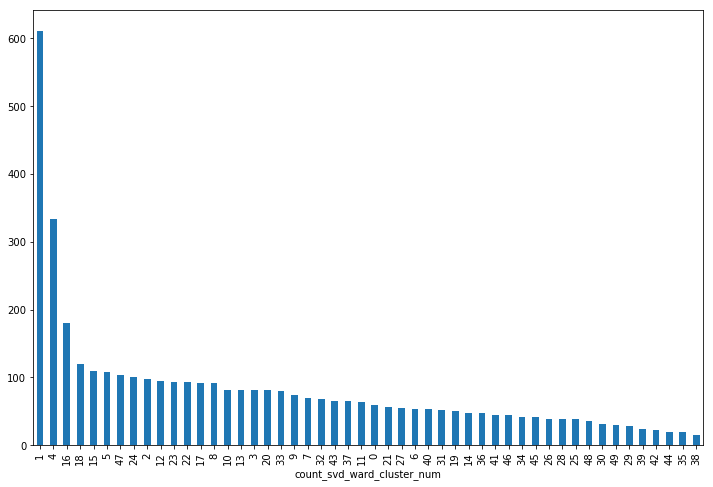

In [93]:
plt.figure(figsize=(12, 8))
tmp.groupby('count_svd_ward_cluster_num').size().sort_values(ascending=False).plot(kind="bar")

In [97]:
count_svd_ward_top_clusters = tmp.loc[tmp['count_svd_ward_cluster_num'].isin(tmp.groupby('count_svd_ward_cluster_num').size().sort_values(ascending=False)[:8].index.tolist())]

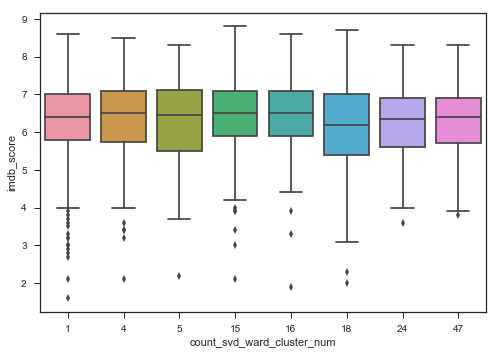

In [101]:
sns.boxplot(x='count_svd_ward_cluster_num', y='imdb_score', data=count_svd_ward_top_clusters)

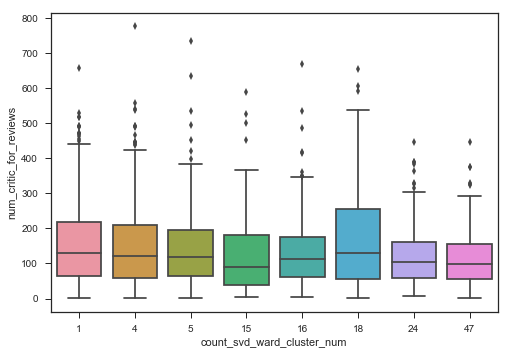

In [102]:
sns.boxplot(x='count_svd_ward_cluster_num', y='num_critic_for_reviews', data=count_svd_ward_top_clusters)

It looks like there is no imdb_score difference in these top 8 clusters, but I guess that doesn't necessarily mean that this result is bad.

In [103]:
tmp = copy.deepcopy(storyline_train)
tmp['count_svd_ward_cluster_num'] = count_svd_ward_best_model.fit_predict(tmp['storyline'])

In [107]:
tmp.loc[tmp['count_svd_ward_cluster_num'] == tmp.loc['Inception\xc2\xa0']['count_svd_ward_cluster_num']]

,storyline,imdb_score,num_critic_for_reviews,count_svd_ward_cluster_num
movie_title,,,,
Toy Story 3,"Woody, Buzz and the whole gang are back. As th...",8.3,453.0,17
Inception,"Dom Cobb is a skilled thief, the absolute best...",8.8,642.0,17
Watchmen,In a gritty and alternate 1985 the glory days ...,7.7,451.0,17
Sahara,Master explorer and former US Navy Seal Dirk P...,6.0,163.0,17
Fast Five,Former cop Brian O'Conner partners with ex-con...,7.3,342.0,17
Enemy at the Gates,"In World War II, the fall of Stalingrad will m...",7.6,187.0,17
Red Dragon,3 Years after retiring from the FBI because of...,7.2,210.0,17
I Spy,"When the Switchblade, the most sophisticated p...",5.4,105.0,17
Wyatt Earp,Wyatt Earp is a movie about a man and his fami...,6.6,40.0,17


### Agglomerative Clustering with Complete linkage criterion
Use SVD to reduce dimensions

In [23]:
pipe_count_svd_complete = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list,
                                                          tokenizer=custom_tokenizer,
                                                          ngram_range=(1,4))),
                               ('svd', TruncatedSVD()),
                               ('normalizer', Normalizer(copy=False)),
                               ('clustering', AgglomerativeClustering(linkage="complete"))
                              ])

param_grid_svd_complete = {'vectorizer__max_df':[0.5,0.6,0.7,0.8],
                       'vectorizer__min_df':list(np.arange(5,9)),
                       'svd__n_components':[50,75,100,125],
                       'clustering__n_clusters':[10, 30, 50]}
param_grid_svd_complete = list(ParameterGrid(param_grid_svd_complete))

In [24]:
res_count_svd_complete = clustering_grid_search_text(storyline_train, "storyline", pipe_count_svd_complete, param_grid_svd_complete)

Best parameters combination: {'vectorizer__min_df': 5, 'vectorizer__max_df': 0.5, 'clustering__n_clusters': 50, 'svd__n_components': 50} 
Deviance: 0.484456653919


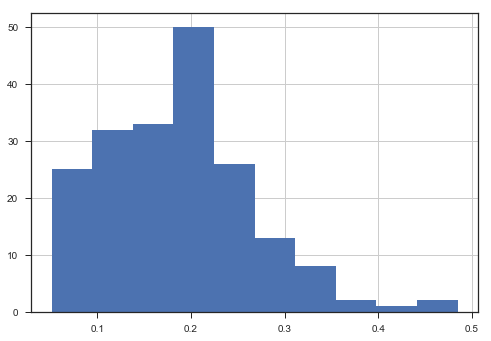

In [25]:
# check deviance distribution
lrs_count_svd_complete = [value[1]['Deviance'] for value in res_count_svd_complete.values()]
pd.Series(lrs_count_svd_complete).hist()

In [26]:
joblib.dump(res_count_svd_complete, 'pickles/count_svd_complete_params.pkl', compress=1) # pickle the parameters and the results

['pickles/count_svd_complete_params.pkl']

#### Investigation

In [28]:
count_svd_complete_best_model = pipe_count_svd_complete.set_params(**param_grid_svd_complete[get_best_model_id(res_count_svd_complete)])

In [29]:
tmp = pd.concat([storyline_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                 pd.Series(count_svd_complete_best_model.fit_predict(storyline_train['storyline']), 
                           name="count_svd_complete_cluster_num")], axis=1)

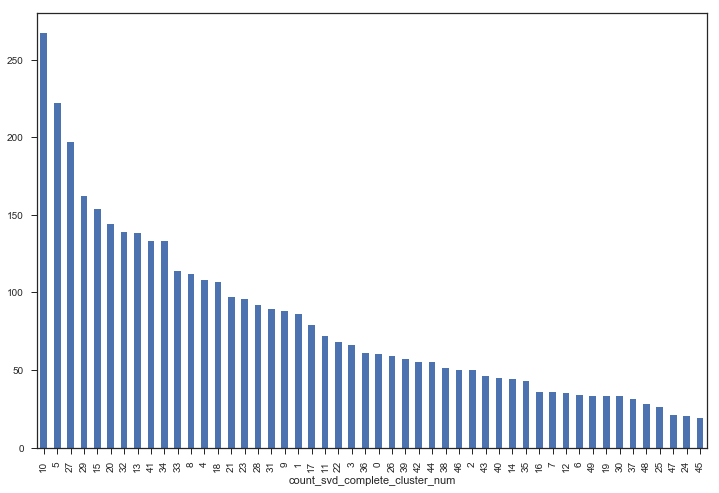

In [30]:
plt.figure(figsize=(12, 8))
tmp.groupby('count_svd_complete_cluster_num').size().sort_values(ascending=False).plot(kind="bar")

In [31]:
count_svd_complete_top_clusters = tmp.loc[tmp['count_svd_complete_cluster_num'].isin(tmp.groupby('count_svd_complete_cluster_num').size().sort_values(ascending=False)[:8].index.tolist())]

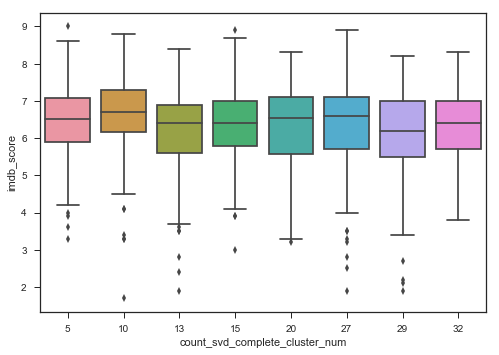

In [32]:
sns.boxplot(x='count_svd_complete_cluster_num', y='imdb_score', data=count_svd_complete_top_clusters)

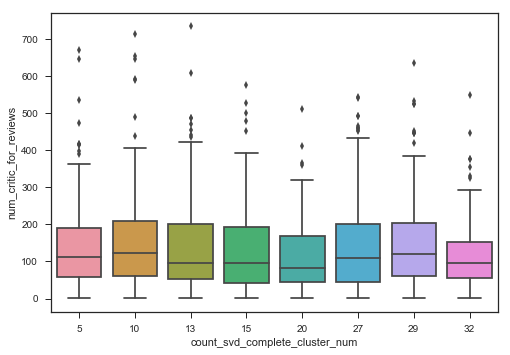

In [33]:
sns.boxplot(x='count_svd_complete_cluster_num', y='num_critic_for_reviews', data=count_svd_complete_top_clusters)

It still doesn't differ that much.

In [34]:
tmp = copy.deepcopy(storyline_train)
tmp['count_svd_complete_cluster_num'] = count_svd_complete_best_model.fit_predict(tmp['storyline'])

In [37]:
tmp.loc[tmp['count_svd_complete_cluster_num'] == tmp.loc['Inception\xc2\xa0']['count_svd_complete_cluster_num']]

,storyline,imdb_score,num_critic_for_reviews,count_svd_complete_cluster_num
movie_title,,,,
Transformers: Revenge of the Fallen,A youth chooses manhood. The week Sam Witwicky...,6.0,366.0,16
Toy Story 3,"Woody, Buzz and the whole gang are back. As th...",8.3,453.0,16
Wreck-It Ralph,Wreck-It Ralph longs to be as beloved as his g...,7.8,377.0,16
Inception,"Dom Cobb is a skilled thief, the absolute best...",8.8,642.0,16
Watchmen,In a gritty and alternate 1985 the glory days ...,7.7,451.0,16
Fast Five,Former cop Brian O'Conner partners with ex-con...,7.3,342.0,16
Batman & Robin,Batman and Robin are back working side-by-side...,3.7,183.0,16
RoboCop,The year is 2028 and multinational conglomerat...,6.2,492.0,16
Oblivion,One of the few remaining drone repairmen assig...,7.0,539.0,16


### Agglomerative Clustering with Average linkage criterion
Use SVD to reduce dimensions

In [38]:
pipe_count_svd_average = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list,
                                                          tokenizer=custom_tokenizer,
                                                          ngram_range=(1,4))),
                               ('svd', TruncatedSVD()),
                               ('normalizer', Normalizer(copy=False)),
                               ('clustering', AgglomerativeClustering(linkage="average"))
                              ])

param_grid_svd_average = {'vectorizer__max_df':[0.5,0.6,0.7,0.8],
                       'vectorizer__min_df':list(np.arange(5,9)),
                       'svd__n_components':[50,75,100,125],
                       'clustering__n_clusters':[10, 30, 50]}
param_grid_svd_average = list(ParameterGrid(param_grid_svd_average))

In [39]:
res_count_svd_average = clustering_grid_search_text(storyline_train, "storyline", pipe_count_svd_average, param_grid_svd_average)

C:\users\usz0b3l\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


Best parameters combination: {'vectorizer__min_df': 6, 'vectorizer__max_df': 0.6, 'clustering__n_clusters': 50, 'svd__n_components': 50} 
Deviance: 0.58637590209


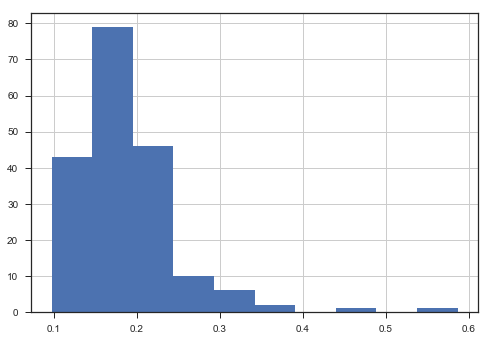

In [40]:
# check deviance distribution
lrs_count_svd_average = [value[1]['Deviance'] for value in res_count_svd_average.values()]
pd.Series(lrs_count_svd_average).hist()

The two high values are probably just because of randomness.

In [41]:
joblib.dump(res_count_svd_average, 'pickles/count_svd_average_params.pkl', compress=1) # pickle the parameters and the results

['pickles/count_svd_average_params.pkl']

#### Investigation

In [42]:
count_svd_average_best_model = pipe_count_svd_average.set_params(**param_grid_svd_average[get_best_model_id(res_count_svd_average)])

In [45]:
tmp = pd.concat([storyline_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                 pd.Series(count_svd_average_best_model.fit_predict(storyline_train['storyline']), 
                           name="count_svd_average_cluster_num")], axis=1)

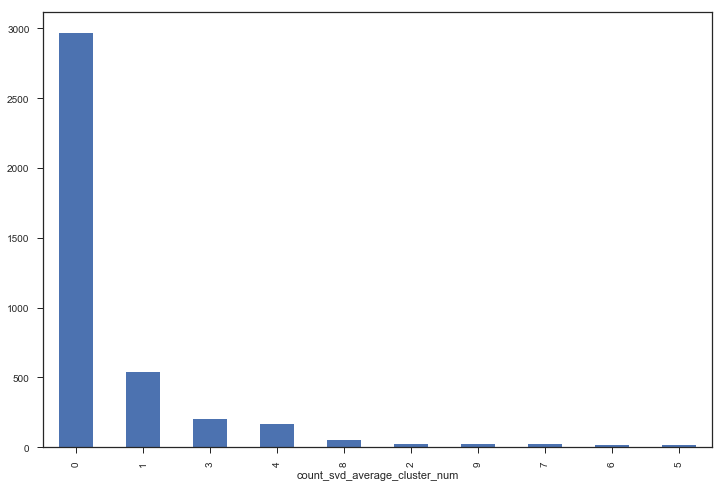

In [50]:
plt.figure(figsize=(12, 8))
tmp.groupby('count_svd_average_cluster_num').size().sort_values(ascending=False).plot(kind="bar")

The result is very different from the above.

In [47]:
count_svd_average_top_clusters = tmp.loc[tmp['count_svd_average_cluster_num'].isin(tmp.groupby('count_svd_average_cluster_num').size().sort_values(ascending=False)[:8].index.tolist())]

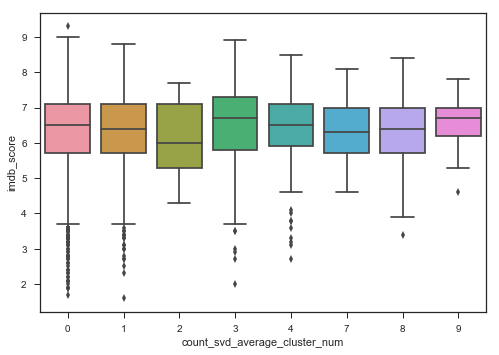

In [48]:
sns.boxplot(x='count_svd_average_cluster_num', y='imdb_score', data=count_svd_average_top_clusters)

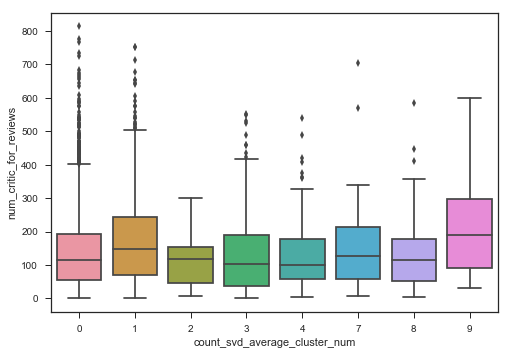

In [49]:
sns.boxplot(x='count_svd_average_cluster_num', y='num_critic_for_reviews', data=count_svd_average_top_clusters)

It still doesn't differ that much.

In [51]:
tmp = copy.deepcopy(storyline_train)
tmp['count_svd_average_cluster_num'] = count_svd_average_best_model.fit_predict(tmp['storyline'])

In [52]:
tmp.loc[tmp['count_svd_average_cluster_num'] == tmp.loc['Inception\xc2\xa0']['count_svd_average_cluster_num']]

,storyline,imdb_score,num_critic_for_reviews,count_svd_average_cluster_num
movie_title,,,,
Avatar,"When his brother is killed in a robbery, parap...",7.9,723.0,1
The Dark Knight Rises,Despite his tarnished reputation after the eve...,8.5,813.0,1
Tangled,After receiving the healing powers from a magi...,7.8,324.0,1
Harry Potter and the Half-Blood Prince,In the sixth year at Hogwarts School of Witchc...,7.5,375.0,1
Man of Steel,A young boy learns that he has extraordinary p...,7.2,733.0,1
The Chronicles of Narnia: Prince Caspian,A year has passed by since the Pevensie childr...,6.6,258.0,1
Men in Black 3,After breaking out of a moon-based maximum sec...,6.8,451.0,1
The Golden Compass,It was no ordinary life for a young girl: livi...,6.1,251.0,1
King Kong,Carl Denham needs to finish his movie and has ...,7.2,446.0,1


It looks similar to the codified result, but this cluster is too big.

### KMeans with CountVectorizer
Use SVD to reduce dimensions

In [53]:
pipe_count_svd_kmeans = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list,
                                                          tokenizer=custom_tokenizer,
                                                          ngram_range=(1,4))),
                                  ('svd', TruncatedSVD()),
                                  ('normalizer', Normalizer(copy=False)),
                                  ('clustering', KMeans(n_jobs=-2))
                                ])

param_grid_svd_kmeans = {'vectorizer__max_df':[0.5,0.6,0.7,0.8],
                         'vectorizer__min_df':list(np.arange(5,9)),
                         'svd__n_components':[50,75,100,125],
                         'clustering__n_clusters':[10, 30, 50]}
param_grid_svd_kmeans = list(ParameterGrid(param_grid_svd_kmeans))

In [54]:
res_count_svd_kmeans = clustering_grid_search_text(storyline_train, "storyline", pipe_count_svd_kmeans, param_grid_svd_kmeans)

Best parameters combination: {'vectorizer__min_df': 5, 'vectorizer__max_df': 0.7, 'clustering__n_clusters': 50, 'svd__n_components': 50} 
Deviance: 0.388413200949


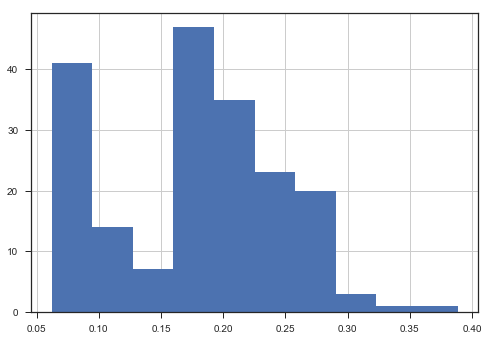

In [55]:
# check deviance distribution
lrs_count_svd_kmeans = [value[1]['Deviance'] for value in res_count_svd_kmeans.values()]
pd.Series(lrs_count_svd_kmeans).hist()

In [56]:
joblib.dump(res_count_svd_kmeans, 'pickles/count_svd_kmeans_params.pkl', compress=1) # pickle the parameters and the results

['pickles/count_svd_kmeans_params.pkl']

#### Investigation

In [71]:
count_svd_kmeans_best_model = pipe_count_svd_kmeans.set_params(**param_grid_svd_kmeans[get_best_model_id(res_count_svd_kmeans)])

In [72]:
tmp = pd.concat([storyline_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                 pd.Series(count_svd_kmeans_best_model.fit_predict(storyline_train['storyline']), 
                           name="count_svd_kmeans_cluster_num")], axis=1)

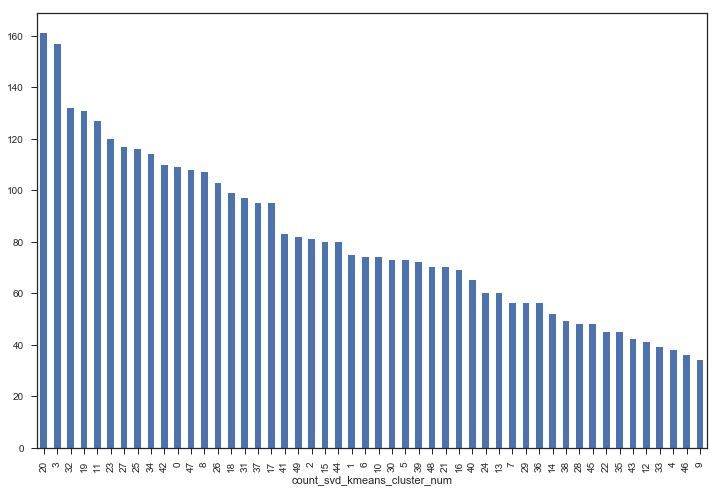

In [73]:
plt.figure(figsize=(12, 8))
tmp.groupby('count_svd_kmeans_cluster_num').size().sort_values(ascending=False).plot(kind="bar")

In [74]:
count_svd_kmeans_top_clusters = tmp.loc[tmp['count_svd_kmeans_cluster_num'].isin(tmp.groupby('count_svd_kmeans_cluster_num').size().sort_values(ascending=False)[:8].index.tolist())]

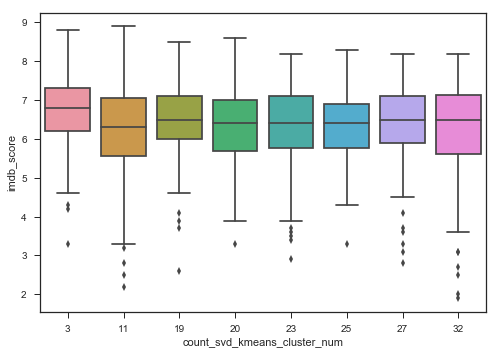

In [75]:
sns.boxplot(x='count_svd_kmeans_cluster_num', y='imdb_score', data=count_svd_kmeans_top_clusters)

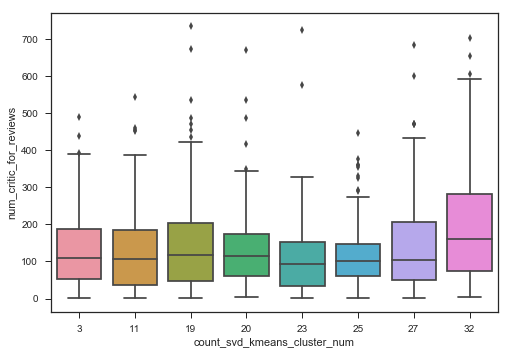

In [76]:
sns.boxplot(x='count_svd_kmeans_cluster_num', y='num_critic_for_reviews', data=count_svd_kmeans_top_clusters)

It looks similar to the above result.

In [77]:
tmp = copy.deepcopy(storyline_train)
tmp['count_svd_kmeans_cluster_num'] = count_svd_kmeans_best_model.fit_predict(tmp['storyline'])

In [78]:
tmp.loc[tmp['count_svd_kmeans_cluster_num'] == tmp.loc['Inception\xc2\xa0']['count_svd_kmeans_cluster_num']]

,storyline,imdb_score,num_critic_for_reviews,count_svd_kmeans_cluster_num
movie_title,,,,
Guardians of the Galaxy,After stealing a mysterious orb in the far rea...,8.1,653.0,21
Inception,"Dom Cobb is a skilled thief, the absolute best...",8.8,642.0,21
G-Force,The story is about a team of trained secret ag...,5.1,145.0,21
Mission: Impossible - Ghost Protocol,In the fourth installment of the Mission Impos...,7.4,432.0,21
Lethal Weapon 4,"Martin Riggs and Roger Murtaugh, after escapin...",6.6,141.0,21
Fast Five,Former cop Brian O'Conner partners with ex-con...,7.3,342.0,21
The Expendables 3,"Barney (Stallone), Christmas (Statham) and the...",6.1,320.0,21
Mission to Mars,"In 2020, a crew of astronauts has been prepare...",5.6,181.0,21
Mission: Impossible,Based on the hit T.V. series. Jim Phelps was s...,7.1,154.0,21


This cluster looks interesting. It's a quite different group of movies.

### DBSCAN with CountVectorizer
Use SVD to reduce dimensions

In [67]:
pipe_count_svd_dbscan = Pipeline([('vectorizer', CountVectorizer(stop_words=stop_list,
                                                          tokenizer=custom_tokenizer,
                                                          ngram_range=(1,4))),
                                  ('svd', TruncatedSVD()),
                                  ('normalizer', Normalizer(copy=False)),
                                  ('clustering', DBSCAN(n_jobs=-2))
                                ])

param_grid_svd_dbscan = {'vectorizer__max_df':[0.5,0.6,0.7,0.8],
                         'vectorizer__min_df':list(np.arange(5,9)),
                         'svd__n_components':[50,75,100,125],
                         'clustering__eps':[0.5,0.7,0.9],
                         'clustering__min_samples':[10,20,30]}
param_grid_svd_dbscan = list(ParameterGrid(param_grid_svd_dbscan))

In [68]:
res_count_svd_dbscan = clustering_grid_search_text(storyline_train, "storyline", pipe_count_svd_dbscan, param_grid_svd_dbscan)

Best parameters combination: {'vectorizer__min_df': 7, 'clustering__min_samples': 10, 'clustering__eps': 0.9, 'vectorizer__max_df': 0.5, 'svd__n_components': 50} 
Deviance: 0.511776050983


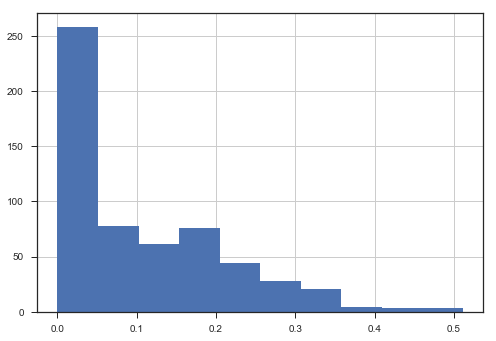

In [69]:
# check deviance distribution
lrs_count_svd_dbscan = [value[1]['Deviance'] for value in res_count_svd_dbscan.values()]
pd.Series(lrs_count_svd_dbscan).hist()

In [70]:
joblib.dump(res_count_svd_dbscan, 'pickles/count_svd_dbscan_params.pkl', compress=1) # pickle the parameters and the results

['pickles/count_svd_dbscan_params.pkl']

#### Investigation

In [79]:
count_svd_dbscan_best_model = pipe_count_svd_dbscan.set_params(**param_grid_svd_dbscan[get_best_model_id(res_count_svd_dbscan)])

In [80]:
tmp = pd.concat([storyline_train[['imdb_score', 'num_critic_for_reviews']].copy().reset_index(drop=True), 
                 pd.Series(count_svd_dbscan_best_model.fit_predict(storyline_train['storyline']), 
                           name="count_svd_dbscan_cluster_num")], axis=1)

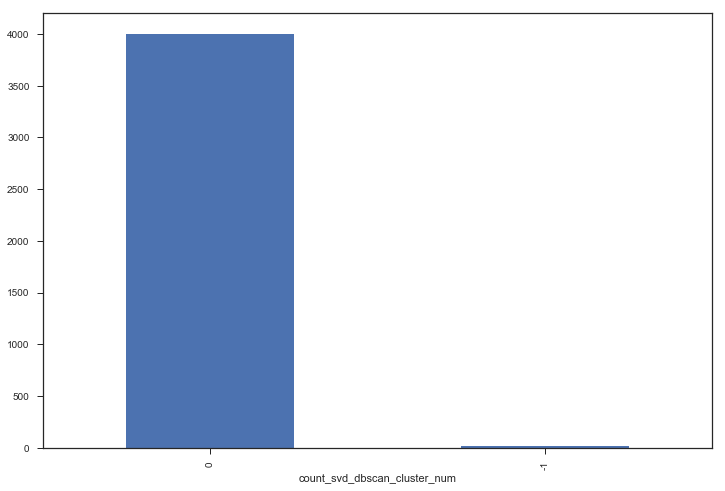

In [81]:
plt.figure(figsize=(12, 8))
tmp.groupby('count_svd_dbscan_cluster_num').size().sort_values(ascending=False).plot(kind="bar")

It doesn't really make sense... So basically except a few outliers, everything else is in the same cluster...